# Project 5B: Training Your Own Diffusion Model!

## Setup environment

In [1]:
# You could delete the code between the dots
# if you don't want to mount the drive.
''' Start here. '''

# Use Google Drive to save the outputs.
from google.colab import drive
drive.mount('/content/drive')

''' End here. '''

# You could modify this to be False,
# if you don't want to save the output images.
toSave = True

Mounted at /content/drive


In [2]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.0 MB/s eta 0:00:00


In [3]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import os
import numpy as np
from mediapy import show_video, write_video, show_image, write_image
import random

device = 'cuda'

# Part 1: Training a Single-step Denoising UNet


In [4]:
# Set the path to save the results of this part.
output_dir = './drive/MyDrive/output/B1'
os.makedirs(output_dir, exist_ok=True)

## Implementing Simple and Composed Ops

In [5]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activation(self.bn(self.conv(x)))


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activation(self.bn(self.conv(x)))


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activation(self.bn(self.conv(x)))


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg_pool = nn.AvgPool2d(kernel_size=7)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.activation(self.avg_pool(x))
        return x.view(x.size(0), -1)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0)
        self.bn = nn.BatchNorm2d(in_channels)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1, 1, 1)
        return self.activation(self.bn(self.conv(x)))


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv2(self.conv1(x))


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downconv = DownConv(in_channels, out_channels)
        self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.convblock(self.downconv(x))


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = UpConv(in_channels, out_channels)
        self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.convblock(self.upconv(x))

## Implementing Unconditional UNet

In [6]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int = 64,
    ):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.convblock2 = ConvBlock(num_hiddens * 2, num_hiddens)

        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.upblock1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.upblock2 = UpBlock(num_hiddens * 2, num_hiddens)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        self.conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        x = self.convblock1(x)
        x1 = self.downblock1(x)
        x2 = self.downblock2(x1)
        x3 = self.flatten(x2)
        x4 = self.unflatten(x3)
        x5 = torch.cat([x2, x4], dim=1)
        x6 = self.upblock1(x5)
        x7 = torch.cat([x1, x6], dim=1)
        x8 = self.upblock2(x7)
        x9 = torch.cat([x, x8], dim=1)

        return self.conv(self.convblock2(x9))

## Using the UNet to Train a Denoiser

In [7]:
# Download the training data.
training_data = MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

testing_data = MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.5MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 473kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.67MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.2MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



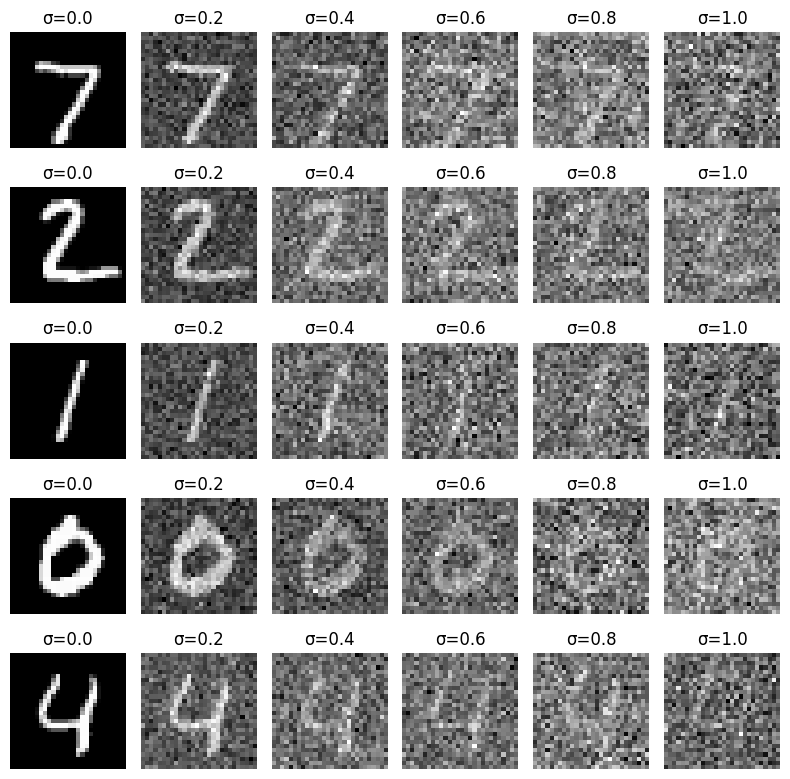

In [8]:
# Add noise to the original image.
def add_noise(im, sigma):
    return im.float() + torch.randn_like(im) * sigma

# Set the hyperparameters.
sigma = 0.5
num_hidden = 128
batch_size = 256
num_epochs = 5
learning_rate = 1e-4

# Create the dataloaders on MNIST with train/test split.
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=1, shuffle=False)

# Set the value of sigma.
sigmas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

sample_images = [test_loader.dataset[i][0].to(device) for i in range(5)]
fig, axes = plt.subplots(len(sample_images), len(sigmas), figsize=(8, 8))
for row, img in enumerate(sample_images):
  for col, sigma in enumerate(sigmas):
    noisy_img = add_noise(img.unsqueeze(0), sigma)
    axes[row, col].imshow(noisy_img.cpu().squeeze(), cmap='gray')
    axes[row, col].set_title(f"σ={sigma}")
    axes[row, col].axis('off')
plt.tight_layout()
if toSave:
  plt.savefig(os.path.join(output_dir, 'noise.png'), dpi=300, bbox_inches='tight')
plt.show()

### Training

Epoch [1/5], Loss: 0.0213


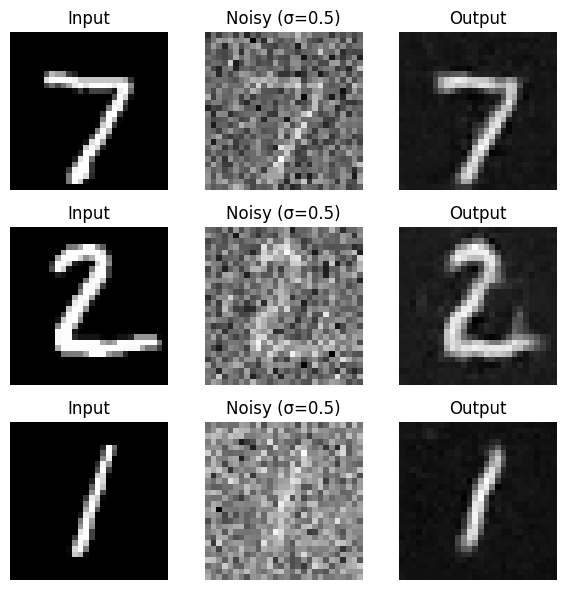

Epoch [2/5], Loss: 0.0107
Epoch [3/5], Loss: 0.0093
Epoch [4/5], Loss: 0.0087
Epoch [5/5], Loss: 0.0083


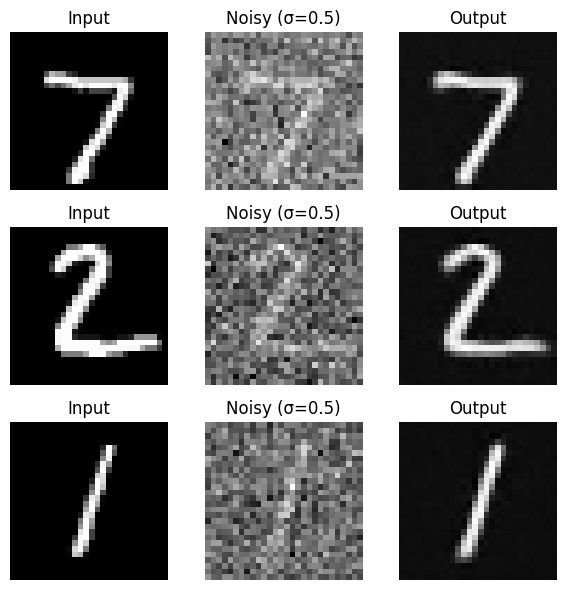

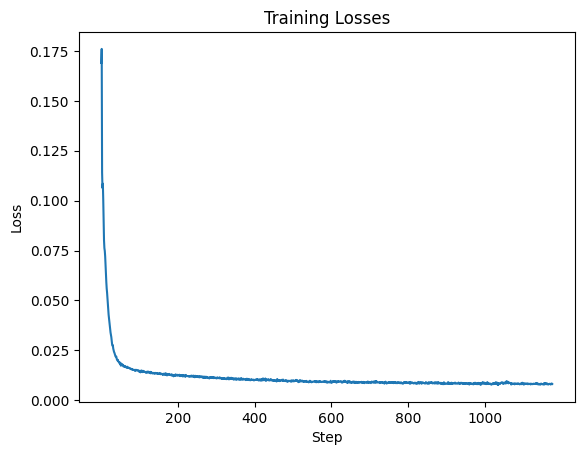

In [9]:
# Create the model and optimizer.
model = UnconditionalUNet(in_channels=1, num_hiddens=num_hidden).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Save the information of iteration loss.
iteration_losses = []

# The loss function.
criterion = nn.MSELoss()

# Set the value of sigma.
sigma = 0.5

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0.0

  for clean_images, label in train_loader:
    clean_images = clean_images.to(device)
    noisy_images = add_noise(clean_images, sigma).to(device)

    outputs = model(noisy_images)
    loss = criterion(outputs, clean_images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * noisy_images.size(0)
    iteration_losses.append(loss.item())

  avg_loss = epoch_loss / len(train_loader.dataset)
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

  if epoch == 0 or epoch == 4:
    model.eval()
    with torch.no_grad():
      sample_images = [test_loader.dataset[i][0].to(device) for i in range(3)]

      fig, axes = plt.subplots(3, 3, figsize=(6, 6))
      for i, sample in enumerate(sample_images):
        sample_noisy = add_noise(sample, sigma).to(device)
        sample_noisy = sample_noisy.unsqueeze(0)
        output = model(sample_noisy)

        axes[i, 0].imshow(sample.cpu().squeeze(), cmap='gray')
        axes[i, 0].set_title('Input')
        axes[i, 1].imshow(sample_noisy.cpu().squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Noisy (σ={sigma})')
        axes[i, 2].imshow(output.cpu().squeeze(), cmap='gray')
        axes[i, 2].set_title('Output')
        for j in range(3):
          axes[i, j].axis('off')
      plt.tight_layout()
      if toSave:
        plt.savefig(os.path.join(output_dir, f'training_result{epoch + 1}.png'), dpi=300, bbox_inches='tight')
      plt.show()

plt.plot(range(1, len(iteration_losses) + 1), iteration_losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.xticks(range(200, len(iteration_losses) + 1, 200))
if toSave:
  plt.savefig(os.path.join(output_dir, 'training_loss.png'), dpi=300, bbox_inches='tight')
plt.show()

### Out-of-Distribution Testing

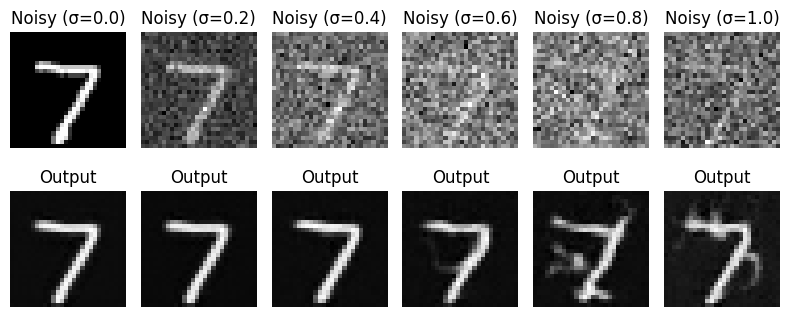

In [10]:
# Set the value of sigma.
sigmas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

model.eval()
with torch.no_grad():
  sample_clean, _ = next(iter(test_loader))
  sample_clean = sample_clean.to(device)

  fig, axes = plt.subplots(2, len(sigmas), figsize=(8, 3.5))
  for i, sigma in enumerate(sigmas):
    sample_noisy = add_noise(sample_clean, sigma).to(device)
    output = model(sample_noisy)

    axes[0, i].imshow(sample_noisy.cpu().squeeze(), cmap='gray')
    axes[0, i].set_title(f'Noisy (σ={sigma})')
    axes[0, i].axis('off')
    axes[1, i].imshow(output.cpu().squeeze(), cmap='gray')
    axes[1, i].set_title(f'Output')
    axes[1, i].axis('off')
  plt.tight_layout()
  if toSave:
    plt.savefig(os.path.join(output_dir, 'test_result.png'), dpi=300, bbox_inches='tight')
  plt.show()


# Part 2: Training a Diffusion Model

In [11]:
# Set the path to save the results of this part.
output_dir = './drive/MyDrive/output/B2'
os.makedirs(output_dir, exist_ok=True)

## Implementing a Time-conditioned UNet

In [12]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.fc2 = nn.Linear(out_channels, out_channels)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.activation(self.fc1(x)))


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.num_hiddens = num_hiddens

        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc2_t = FCBlock(1, num_hiddens)

        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.convblock2 = ConvBlock(num_hiddens * 2, num_hiddens)

        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.upblock1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.upblock2 = UpBlock(num_hiddens * 2, num_hiddens)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        self.conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        t1 = self.fc1_t(t).unsqueeze(-1).unsqueeze(-1)
        t2 = self.fc2_t(t).unsqueeze(-1).unsqueeze(-1)

        x0 = self.convblock1(x)
        x1 = self.downblock1(x0)
        x2 = self.downblock2(x1)
        x3 = self.flatten(x2)
        x4 = self.unflatten(x3) + t1
        x5 = torch.cat([x2, x4], dim=1)
        x6 = self.upblock1(x5) + t2
        x7 = torch.cat([x1, x6], dim=1)
        x8 = self.upblock2(x7)
        x9 = torch.cat([x0, x8], dim=1)

        return self.conv(self.convblock2(x9))

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [13]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    betas = torch.linspace(beta1, beta2, num_ts)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    return {
        'betas': betas,
        'alphas': alphas,
        'alpha_bars': alpha_bars
    }

In [14]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    alpha_bars = ddpm_schedule['alpha_bars'].to(device)
    sqrt_alpha_bars = torch.sqrt(alpha_bars).to(device)
    sqrt_1m_alpha_bars = torch.sqrt(1 - alpha_bars).to(device)

    t = torch.randint(0, num_ts, (x_0.shape[0],1), device=device)
    epsilon = torch.randn_like(x_0).to(device)
    sqrt_alpha_bar_t = sqrt_alpha_bars[t].view(-1, 1, 1, 1)
    sqrt_1m_alpha_bar_t = sqrt_1m_alpha_bars[t].view(-1, 1, 1, 1)
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_1m_alpha_bar_t * epsilon
    epsilon_est = unet(x_t.clone(), (t / num_ts).float()).to(device)

    return torch.mean((epsilon_est - epsilon) ** 2)

In [15]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # YOUR CODE HERE.
    H, W = img_wh
    torch.cuda.manual_seed(seed)
    x = torch.randn(batch_size, 1, H, W, device=device)

    caches = []

    betas = ddpm_schedule['betas'].to(device)
    sqrt_betas = torch.sqrt(betas).to(device)
    alphas = ddpm_schedule['alphas'].to(device)
    sqrt_alphas = torch.sqrt(alphas).to(device)
    alpha_bars = ddpm_schedule['alpha_bars'].to(device)
    alpha_bars_1m = (1 - alpha_bars).to(device)
    sqrt_alpha_bars = torch.sqrt(alpha_bars).to(device)
    inv_1m_alpha_bars = (1 / (1 - alpha_bars)).to(device)
    sqrt_1m_alpha_bars = torch.sqrt(1 - alpha_bars).to(device)
    inv_sqrt_alphas_bars = (1 / torch.sqrt(alpha_bars)).to(device)

    for t in reversed(range(num_ts)):
      torch.cuda.manual_seed(seed)
      seed = seed + 1

      betas_t = betas[t].view(-1, 1, 1, 1)
      sqrt_betas_t = sqrt_betas[t].view(-1, 1, 1, 1)
      sqrt_alphas_t = sqrt_alphas[t].view(-1, 1, 1, 1)
      alpha_bars_1m_t_1 = alpha_bars_1m[t-1].view(-1, 1, 1, 1)
      inv_1m_alpha_bars_t = inv_1m_alpha_bars[t].view(-1, 1, 1, 1)
      sqrt_1m_alpha_bars_t = sqrt_1m_alpha_bars[t].view(-1, 1, 1, 1)
      sqrt_alpha_bars_t_1 = sqrt_alpha_bars[t-1].view(-1, 1, 1, 1)
      inv_sqrt_alphas_bars_t = inv_sqrt_alphas_bars[t].view(-1, 1, 1, 1)

      epsilon = unet(x.clone(), (torch.ones((x.shape[0],)).float() * (t/num_ts)).view(-1, 1).to(device)).float().to(device)
      x_est = inv_sqrt_alphas_bars_t * (x - sqrt_1m_alpha_bars_t * epsilon)
      z = torch.randn_like(x).to(device) if t > 0 else torch.zeros_like(x).to(device)
      x = sqrt_alpha_bars_t_1 * betas_t * inv_1m_alpha_bars_t * x_est.to(device) +\
         sqrt_alphas_t * alpha_bars_1m_t_1 * inv_1m_alpha_bars_t * x +\
         sqrt_betas_t * z

      if t % 20 == 0 or t == num_ts - 1 or t < 8:
          caches.append(x.clone())

    return caches[len(caches)-2], torch.stack(caches, dim=1)

In [16]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas_tuple = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in ddpm_schedule(betas[0], betas[1], num_ts).items():
            self.register_buffer(k, v, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

Epoch [1/20], Loss: 0.0006


""

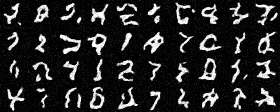

Epoch [2/20], Loss: 0.0004
Epoch [3/20], Loss: 0.0003
Epoch [4/20], Loss: 0.0003
Epoch [5/20], Loss: 0.0003


""

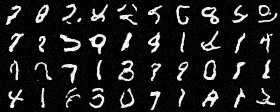

Epoch [6/20], Loss: 0.0003
Epoch [7/20], Loss: 0.0003
Epoch [8/20], Loss: 0.0003
Epoch [9/20], Loss: 0.0003
Epoch [10/20], Loss: 0.0002


""

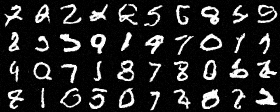

Epoch [11/20], Loss: 0.0002
Epoch [12/20], Loss: 0.0002
Epoch [13/20], Loss: 0.0002
Epoch [14/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0002


""

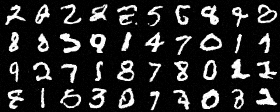

Epoch [16/20], Loss: 0.0002
Epoch [17/20], Loss: 0.0002
Epoch [18/20], Loss: 0.0002
Epoch [19/20], Loss: 0.0002
Epoch [20/20], Loss: 0.0002


""

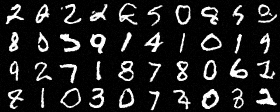

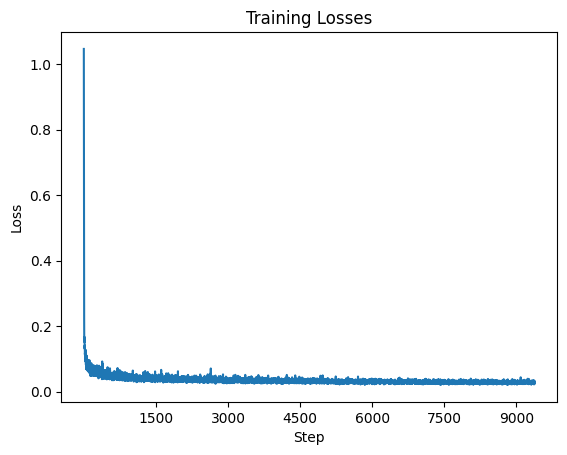

In [17]:
# Set the hyperparameters.
num_hidden = 64
batch_size = 128
num_epochs = 20
learning_rate = 1e-3
num_ts = 300

# Create the dataloaders on MNIST with train/test split.
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=1, shuffle=False)

# Create the model, optimizer and scheduler.
tc_unet=TimeConditionalUNet(in_channels=1,
            num_classes=10,
            num_hiddens=num_hidden
).to(device)
tc_ddpm_model = DDPM(unet=tc_unet,
        betas=(1e-4, 0.02),
        num_ts=num_ts,
        p_uncond=0.1
).to(device)
optimizer_ddpm_tc = optim.Adam(tc_ddpm_model.parameters(), lr=learning_rate)
gamma = 0.1 ** (1.0 / num_epochs)
scheduler_tc = optim.lr_scheduler.ExponentialLR(optimizer_ddpm_tc, gamma=gamma)

iteration_losses = []
for epoch in range(num_epochs):
  tc_ddpm_model.train()
  epoch_loss = 0.0

  for clean_images, label in train_loader:
    loss = tc_ddpm_model(clean_images.to(device))

    optimizer_ddpm_tc.zero_grad()
    loss.backward()
    optimizer_ddpm_tc.step()

    epoch_loss += loss.item()
    iteration_losses.append(loss.item())

  scheduler_tc.step()

  avg_loss = epoch_loss / len(train_loader.dataset)
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

  if (epoch == 0) or ((epoch + 1) % 5 == 0) or (epoch == num_epochs - 1):
    tc_ddpm_model.eval()
    with torch.no_grad():
      x0, anims = tc_ddpm_model.sample((28, 28), 0)

      x0_frame = np.zeros((112, 280), dtype=np.float32)
      for i in range(4):
        for j in range(10):
          x0_np = x0[i * 10 + j].squeeze().cpu().numpy()
          x0_frame[i*28:(i+1)*28, j*28:(j+1)*28] = x0_np
          x0_rgb = np.repeat(x0_frame[:, :, np.newaxis], 3, axis=-1)
      show_image(x0_rgb)
      write_image(os.path.join(output_dir, f'tc_sample{epoch + 1}.png'), x0_rgb)

      caches_np_rgb = []
      for t in range(anims[0].shape[0]):
        grid_frame = np.zeros((112, 280), dtype=np.float32)
        for i in range(4):
          for j in range(10):
            index = i * 10 + j
            cache = anims[index][t].squeeze().cpu().numpy()
            grid_frame[i*28:(i+1)*28, j*28:(j+1)*28] = cache
        grid_frame_rgb = np.repeat(grid_frame[:, :, np.newaxis], 3, axis=-1)
        caches_np_rgb.append(grid_frame_rgb)
      write_video(os.path.join(output_dir, f'tc_sample{epoch + 1}.gif'), caches_np_rgb, fps=16, codec='gif')

plt.plot(range(1, len(iteration_losses) + 1), iteration_losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.xticks(range(1500, len(iteration_losses) + 1, 1500))
if toSave:
  plt.savefig(os.path.join(output_dir, 'tc_training_loss.png'), dpi=300, bbox_inches='tight')
plt.show()

### Implementing class-conditioned UNet

In [18]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.num_hiddens = num_hiddens

        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc1_c = FCBlock(num_classes, num_hiddens * 2)
        self.fc2_t = FCBlock(1, num_hiddens)
        self.fc2_c = FCBlock(num_classes, num_hiddens)

        self.convblock1 = ConvBlock(in_channels, num_hiddens)
        self.convblock2 = ConvBlock(num_hiddens * 2, num_hiddens)

        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.upblock1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.upblock2 = UpBlock(num_hiddens * 2, num_hiddens)

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)

        self.conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        if mask != None:
          c = c * mask

        t1 = self.fc1_t(t).unsqueeze(-1).unsqueeze(-1)
        c1 = self.fc1_c(c).unsqueeze(-1).unsqueeze(-1)
        t2 = self.fc2_t(t).unsqueeze(-1).unsqueeze(-1)
        c2 = self.fc2_c(c).unsqueeze(-1).unsqueeze(-1)

        x0 = self.convblock1(x)
        x1 = self.downblock1(x0)
        x2 = self.downblock2(x1)
        x3 = self.flatten(x2)
        x4 = self.unflatten(x3) * c1 + t1
        x5 = torch.cat([x2, x4], dim=1)
        x6 = self.upblock1(x5) * c2 + t2
        x7 = torch.cat([x1, x6], dim=1)
        x8 = self.upblock2(x7)
        x9 = torch.cat([x0, x8], dim=1)

        return self.conv(self.convblock2(x9))

In [19]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    alpha_bars = ddpm_schedule['alpha_bars'].to(device)
    sqrt_alpha_bars = torch.sqrt(alpha_bars).to(device)
    sqrt_1m_alpha_bars = torch.sqrt(1 - alpha_bars).to(device)

    c_one_hot = F.one_hot(c.long(), num_classes=unet.num_classes).float().to(device)
    mask = (torch.rand(c_one_hot.shape[0], device=device) > p_uncond).float()
    mask = mask.unsqueeze(1).expand(-1, c_one_hot.shape[1])

    t = torch.randint(0, num_ts, (x_0.shape[0],1), device=device)
    epsilon = torch.randn_like(x_0).to(device)
    sqrt_alpha_bar_t = sqrt_alpha_bars[t].view(-1, 1, 1, 1)
    sqrt_1m_alpha_bar_t = sqrt_1m_alpha_bars[t].view(-1, 1, 1, 1)
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_1m_alpha_bar_t * epsilon
    epsilon_est = unet(x_t.clone(), c_one_hot, (t / num_ts).float(), mask).to(device)

    return torch.mean((epsilon_est - epsilon) ** 2)

In [20]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # YOUR CODE HERE.
    torch.cuda.manual_seed(seed)
    H, W = img_wh
    x = torch.randn(c.shape[0], 1, H, W, device=device)
    c_one_hot = F.one_hot(c.long(), num_classes=unet.num_classes).float().to(device)

    caches = []

    betas = ddpm_schedule['betas'].to(device)
    sqrt_betas = torch.sqrt(betas).to(device)
    alphas = ddpm_schedule['alphas'].to(device)
    sqrt_alphas = torch.sqrt(alphas).to(device)
    alpha_bars = ddpm_schedule['alpha_bars'].to(device)
    alpha_bars_1m = (1 - alpha_bars).to(device)
    sqrt_alpha_bars = torch.sqrt(alpha_bars).to(device)
    inv_1m_alpha_bars = (1 / (1 - alpha_bars)).to(device)
    sqrt_1m_alpha_bars = torch.sqrt(1 - alpha_bars).to(device)
    inv_sqrt_alphas_bars = (1 / torch.sqrt(alpha_bars)).to(device)

    for t in reversed(range(num_ts)):
      torch.cuda.manual_seed(seed)
      seed = seed + 1

      betas_t = betas[t].view(-1, 1, 1, 1)
      sqrt_betas_t = sqrt_betas[t].view(-1, 1, 1, 1)
      sqrt_alphas_t = sqrt_alphas[t].view(-1, 1, 1, 1)
      alpha_bars_1m_t_1 = alpha_bars_1m[t-1].view(-1, 1, 1, 1)
      inv_1m_alpha_bars_t = inv_1m_alpha_bars[t].view(-1, 1, 1, 1)
      sqrt_1m_alpha_bars_t = sqrt_1m_alpha_bars[t].view(-1, 1, 1, 1)
      sqrt_alpha_bars_t_1 = sqrt_alpha_bars[t-1].view(-1, 1, 1, 1)
      inv_sqrt_alphas_bars_t = inv_sqrt_alphas_bars[t].view(-1, 1, 1, 1)


      epsilon_u = unet(x.clone(), c_one_hot, (torch.ones((x.shape[0],)).float() * (t/num_ts)).view(-1, 1).to(device),
                       mask=torch.zeros(c_one_hot.shape, device=device).float()).float().to(device)
      epsilon_c = unet(x.clone(), c_one_hot, (torch.ones((x.shape[0],)).float() * (t/num_ts)).view(-1, 1).to(device),
                       mask=torch.ones(c_one_hot.shape, device=device).float()).float().to(device)
      epsilon = epsilon_u + guidance_scale * (epsilon_c - epsilon_u)
      x_est = inv_sqrt_alphas_bars_t * (x - sqrt_1m_alpha_bars_t * epsilon)
      z = torch.randn_like(x).to(device) if t > 0 else torch.zeros_like(x).to(device)
      x = sqrt_alpha_bars_t_1 * betas_t * inv_1m_alpha_bars_t * x_est.to(device) +\
         sqrt_alphas_t * alpha_bars_1m_t_1 * inv_1m_alpha_bars_t * x +\
         sqrt_betas_t * z

      if t % 20 == 0 or t == num_ts - 1 or t < 8:
          caches.append(x.clone())

    return caches[len(caches)-2], torch.stack(caches, dim=1)

In [21]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas_tuple = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in ddpm_schedule(betas[0], betas[1], num_ts).items():
            self.register_buffer(k, v, persistent=False)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

Epoch [1/20], Loss: 0.0006


""

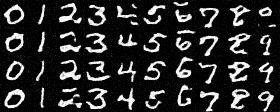

Epoch [2/20], Loss: 0.0003
Epoch [3/20], Loss: 0.0003
Epoch [4/20], Loss: 0.0003
Epoch [5/20], Loss: 0.0003


""

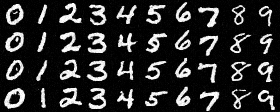

Epoch [6/20], Loss: 0.0002
Epoch [7/20], Loss: 0.0002
Epoch [8/20], Loss: 0.0002
Epoch [9/20], Loss: 0.0002
Epoch [10/20], Loss: 0.0002


""

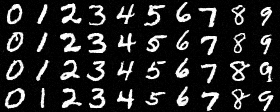

Epoch [11/20], Loss: 0.0002
Epoch [12/20], Loss: 0.0002
Epoch [13/20], Loss: 0.0002
Epoch [14/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0002


""

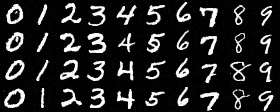

Epoch [16/20], Loss: 0.0002
Epoch [17/20], Loss: 0.0002
Epoch [18/20], Loss: 0.0002
Epoch [19/20], Loss: 0.0002
Epoch [20/20], Loss: 0.0002


""

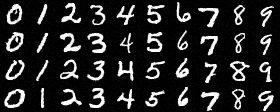

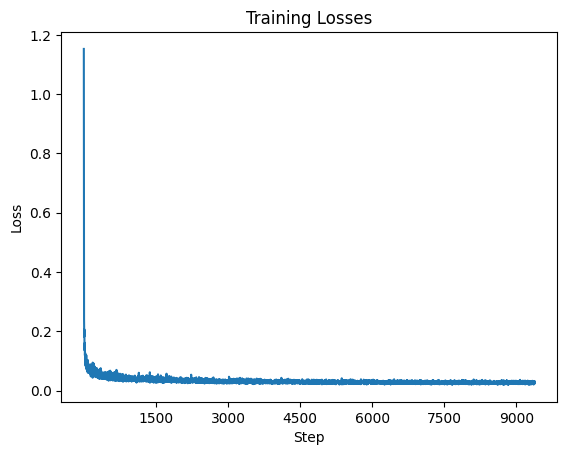

In [22]:
# Set the hyperparameters.
num_hidden = 64
batch_size = 128
num_epochs = 20
learning_rate = 1e-3
num_ts = 300

# Create the dataloaders on MNIST with train/test split.
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=1, shuffle=False)

# Create the model, optimizer and scheduler.
unet=ClassConditionalUNet(in_channels=1,
            num_classes=10,
            num_hiddens=num_hidden
).to(device)
ddpm_model = DDPM(unet=unet,
        betas=(1e-4, 0.02),
        num_ts=num_ts,
        p_uncond=0.1
).to(device)
optimizer_ddpm = optim.Adam(ddpm_model.parameters(), lr=learning_rate)
gamma = 0.1 ** (1.0 / num_epochs)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer_ddpm, gamma=gamma)

iteration_losses = []
for epoch in range(num_epochs):
  ddpm_model.train()
  epoch_loss = 0.0

  for clean_images, labels in train_loader:
    loss = ddpm_model(clean_images.to(device), labels.to(device))

    optimizer_ddpm.zero_grad()
    loss.backward()
    optimizer_ddpm.step()

    epoch_loss += loss.item()
    iteration_losses.append(loss.item())
  scheduler.step()

  avg_loss = epoch_loss / len(train_loader.dataset)
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

  if (epoch == 0) or ((epoch + 1) % 5 == 0) or (epoch == num_epochs - 1):
    ddpm_model.eval()
    with torch.no_grad():
      caches_np_rgb = []
      x0, anims = ddpm_model.sample(torch.tensor([(i % 10) for i in range(40)], device=device), (28, 28))
      x0_frame = np.zeros((112, 280), dtype=np.float32)
      for i in range(4):
        for j in range(10):
          x0_np = x0[i * 10 + j].squeeze().cpu().numpy()
          x0_frame[i*28:(i+1)*28, j*28:(j+1)*28] = x0_np
          x0_rgb = np.repeat(x0_frame[:, :, np.newaxis], 3, axis=-1)
      show_image(x0_rgb)
      write_image(os.path.join(output_dir, f'cc_sample{epoch + 1}.png'), x0_rgb)
      for t in range(anims[0].shape[0]):
        grid_frame = np.zeros((112, 280), dtype=np.float32)
        for j in range(10):
          for i in range(4):
            cache = anims[i * 10 + j][t].squeeze().cpu().numpy()
            grid_frame[i*28:(i+1)*28, j*28:(j+1)*28] = cache
          grid_frame_rgb = np.repeat(grid_frame[:, :, np.newaxis], 3, axis=-1)
        caches_np_rgb.append(grid_frame_rgb)
      write_video(os.path.join(output_dir, f'cc_sample{epoch + 1}.gif'), caches_np_rgb, fps=16, codec='gif')

plt.plot(range(1, len(iteration_losses) + 1), iteration_losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.xticks(range(1500, len(iteration_losses) + 1, 1500))
if toSave:
  plt.savefig(os.path.join(output_dir, 'cc_training_loss.png'), dpi=300, bbox_inches='tight')
plt.show()

guidance scale = 0:


""

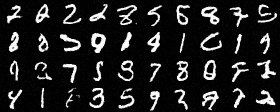

guidance scale = 5:


""

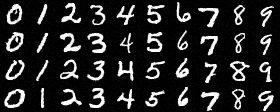

guidance scale = 10:


""

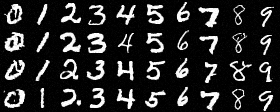

In [23]:
ddpm_model.eval()
with torch.no_grad():
  for guidance_scale in [0, 5, 10]:
    print(f'guidance scale = {guidance_scale}:')
    caches_np_rgb = []
    x0, anims = ddpm_model.sample(torch.tensor([(i % 10) for i in range(40)], device=device), (28, 28), guidance_scale)
    x0_frame = np.zeros((112, 280), dtype=np.float32)
    for i in range(4):
      for j in range(10):
        x0_np = x0[i * 10 + j].squeeze().cpu().numpy()
        x0_frame[i*28:(i+1)*28, j*28:(j+1)*28] = x0_np
        x0_rgb = np.repeat(x0_frame[:, :, np.newaxis], 3, axis=-1)
    show_image(x0_rgb)
    write_image(os.path.join(output_dir, f'guidance_scale{guidance_scale}.png'), x0_rgb)